# Search and merge datasets

### Notebook contents ### 

* Collection of the dataset files from the table by the link below 
* Establishing data types, formats and available values for the initial raw database
* Defining of merge recommendations for the initial database
* Merge
* Studying the basic functionality of the Great Expectations library (additionally-completed)

After execution, saving and sharing the dataset with the command is implied. 

## Data description and dtypes, values schema

* **raw_text_id (int)** — уникальный идентификатор сырой строки.  

* **dataset_id (string)** — идентификатор исходного датасета внутри Google-таблицы;   

* **source_platform (string)** — название платформы или ресурса (сайт, форум и т.д.), откуда получен текст.  
Информация собиралась эмпирически из источников-описаний датасетов (см. ссылки в таблице).   
UPD: не во всех датасетах указаны источники для каждой строки text_raw => некоторые значения в столбце source_platform поданы через запятую как "шапочные", общие значения.  
* **is_verified (float)** — признак того, была ли исходная разметка верифицирована либо вручную, либо автоматически.  
Информация собиралась эмпирически из источников-описаний датасетов.
* **text_raw (string)** — исходный текст сообщения без каких-либо предобработок.  
* **is_toxic (int)** — бинарный целевой признак токсичности сообщения (1 — токсичное, 0 — нетоксичное).   
Допустимые значения: `[0, 1, np.nan]`
* **toxicity_type (string)** — мультиклассовый признак, определяющий тип высказывания в более узкой классификации.   
Допустимые значения: `[SENSITIVE, INSULT, INAPPROPRIATE, THREAT, OBSCENITY, 'UNKNOWN']`.   
UPD: не все бинарные/мультикласс метки присутствуют в разметке, см. в графиках распределения

### Multiclass labels variations ### 
* **INAPPROPRIATE** — Неуместное высказывание. 
* **SENSITIVE** — Чувствительная тема. 


* **INSULT** — Оскорбление.

* **THREAT** — Угроза.
* **OBSCENITY** — Непристойность / вульгарность.

### 'inappropriate' vs 'sensitive' and how to set up `is_toxic` values? ### 
* INAPPROPRIATE. Главный признак INAPPROPRIATE - неуместный способ подачи сказанного (не соответствующая контексту темы интонация, грубая/вульгарная лексика).    
Источник: https://huggingface.co/apanc/russian-inappropriate-messages  
Поэтому для метки INAPPROPRIATE **не стоит** однозначно ставить is_toxic=1.   
* SENSITIVE. Для этой метки важно содержание темы, а не способ подачи.   
Внутри чувствительных тем у высказывания могут быть виды мнений: общественно-неодобряемое и общественно-одобряемое.  
Также для SENSITIVE **также не стоит**  однозначно ставить is_toxic=1.  
Источник: https://aclanthology.org/2021.bsnlp-1.4
* INSULT, THREAT - однозначно is_toxic=1.
* ONSCENITY - не стоит ставить is_toxic=1

In [1]:
!pip install -r requirements.txt

# or 
# !pip install matplotlib pandas numpy great_expectations seaborn 


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Imports

In [2]:
import ast 
import re
import kagglehub
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import great_expectations as gx
import great_expectations.expectations as gxe 


f:\HSE\level-1\Year-project\Sources\toxic-messages-handling-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Downloads

In [3]:
# Download latest version
path = kagglehub.dataset_download("blackmoon/russian-language-toxic-comments")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Anechka\.cache\kagglehub\datasets\blackmoon\russian-language-toxic-comments\versions\1


In [4]:
# Download latest version
path = kagglehub.dataset_download("alexandersemiletov/toxic-russian-comments")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Anechka\.cache\kagglehub\datasets\alexandersemiletov\toxic-russian-comments\versions\1


In [5]:

# Download latest version
path = kagglehub.dataset_download("nigula/russianinappropriatemessages")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Anechka\.cache\kagglehub\datasets\nigula\russianinappropriatemessages\versions\2


## Merge

### Set up merging target schema ##

In [6]:
# target data schema in the result datafra,e: 
TARGET_SCHEMA = {
    'raw_text_id': 'int',
    'dataset_id': 'string',
    'source_platform': 'string', # name of the site/forum/etc
    'is_verified': 'float', # is source data was manually/automaically verified

    'text_raw': 'string', # raw text column
    'is_toxic': 'int',  # binary target column
    'toxicity_type': 'string' # multilabel target column
}
# note: bunch is a local naming for large mergable datasets from the internet and named in the target_schema as dataset_id.


In [7]:
# different columns in sub-datasets to be renamed: 
COLUMNS_MAP = {
    'comment': 'text_raw',
    'text_message': 'text_raw',
    'label_text': 'text_raw',
    'text': 'text_raw',
    'comments': 'text_raw',
    
    'toxic': 'is_toxic', 
    'primary_label': 'toxicity_type',
    'toxicity': 'is_toxic',
    'hate_speech': 'is_toxic',
    'abusive': 'is_toxic',

    'source': 'source_platform',
    # 'author': 'nickname',
}

In [8]:
df_common = pd.DataFrame(columns=TARGET_SCHEMA.keys())
df_common = df_common.astype(TARGET_SCHEMA)

df_common.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   raw_text_id      0 non-null      int64  
 1   dataset_id       0 non-null      string 
 2   source_platform  0 non-null      string 
 3   is_verified      0 non-null      float64
 4   text_raw         0 non-null      string 
 5   is_toxic         0 non-null      int64  
 6   toxicity_type    0 non-null      string 
dtypes: float64(1), int64(2), string(4)
memory usage: 132.0 bytes


In [9]:
df_common.columns

Index(['raw_text_id', 'dataset_id', 'source_platform', 'is_verified',
       'text_raw', 'is_toxic', 'toxicity_type'],
      dtype='object')

### Set up path variables

In [10]:
# path to save dommon df csv: 
df_common_path = 'data/raw/df_common.csv'

# paths of already downloaded datasets from the links (or from the data.zip archive): 
data_0_path = 'data/raw/data_0/labeled.csv'
data_1_txt_path = "data/raw/data_1/dataset.txt"  # txt dataset id 1 
txt_to_csv_path = 'data/raw/data_1/parsed.csv'   # csv path to save txt dataset 1 
data_2_path = 'data/raw/data_2/Inappapropriate_messages.csv'
# dataset4 data is not found
data_4_train_path = 'data/raw/data_4/train-00000-of-00001.parquet'
data_4_test_path = 'data/raw/data_4/test-00000-of-00001.parquet'
data_5_path = 'data/raw/data_5/russian_distorted_toxicity.tsv'
data_6_path = 'data/raw/data_6/labled.csv'
data_7_path = 'data/raw/data_7/final_data.csv'
data_8_path = 'data/raw/data_8/sensitive_topics.csv'

### Great expectations handlers

In [11]:
# base core great expectations context: 
context = gx.get_context(mode="ephemeral")

# register pd datasrouces: 
datasource = context.data_sources.add_or_update_pandas(name="pandas dataframes")
asset = datasource.add_dataframe_asset(name="df_bunch_asset") # header for structural bunch block
batch_definition = asset.add_batch_definition_whole_dataframe("bunch") # structural block for merging dbs

In [12]:
def clear_validation_results(val_results) -> str:
    """returns the more readable version of the results"""
    
    results_dict = val_results.to_json_dict()
        
    rows = []
    for r in results_dict['results']:
        row = {
            "expectation": r['expectation_config']['type'],
            "column": r['expectation_config']['kwargs'].get('column'),
            "success": r['success'],
            "unexpected_count": r['result'].get('unexpected_count'),
            "unexpected_percent": r['result'].get('unexpected_percent'),
            "partial_unexpected_list": r['result'].get('partial_unexpected_list'),
        }
        rows.append(row)
    
    # filter only incorrect info:   
    df_invalid = pd.DataFrame(rows)
    df_invalid = df_invalid[df_invalid['success'] == False]
    
    # more readable version of outputs: 
    message = (
        "Batch is incorrect! The following expectations failed:\n\n" +
        df_invalid.to_string(index=False)
    ) 

    return message

def validate_on_intersections(df_merged): 
    """simple validator for merged data"""

    batch = batch_definition.get_batch(batch_parameters={"dataframe": df_merged})
    validator = context.get_validator(batch=batch)
    validator.expect_column_values_to_be_unique("text_raw")
    results = validator.validate()


    return results


def validate_df_batch(
        df_batch: pd.DataFrame
    ):
    """Great expectations simple workflow for mergable datasets.
    df_batch must be composed bassed on TARGET_SCHEMA. 
    """

    # create batch from df in terms of batch definition: 
    batch = batch_definition.get_batch(batch_parameters={"dataframe": df_batch})

    # Create the batch validator and add its clauses (expectations): 
    validator = context.get_validator(batch=batch)

    for col in TARGET_SCHEMA.keys():
        validator.expect_column_to_exist(col)
    validator.expect_column_values_to_not_be_null("text_raw")
    validator.expect_column_values_to_be_unique("text_raw")

    validator.expect_column_values_to_not_match_regex("text_raw", r"^\s*$")
    # validator.expect_column_values_to_be_unique("raw_text_id")
    validator.expect_column_values_to_be_in_set("is_toxic", [0, 1, ''])
    validator.expect_column_values_to_be_in_set("is_verified", [0, 1])

    # Soft types checking: 
    for col, dtype in TARGET_SCHEMA.items():
        actual = str(df_batch[col].dtype)
        if not actual.startswith(dtype):
            print(f"Warning! Dtype of {col} = {actual}, expected {dtype}")

    # Start validator: 
    results = validator.validate()

    # Check results: 
    if not results.success:
        message = clear_validation_results(results)
        raise ValueError(message)
    else: 
        print('Batch is valid!')

    return results

def merge_on_schema(df: pd.DataFrame, df_bunch: pd.DataFrame) -> pd.DataFrame:
    """df_bunch is the abstract name of large courpuses collected in the internet 
    (especially passed for this notebook).

    validate_df_batch may be used in the another mergable datasets. 
    """

    def reset_indexes(df, df_bunch):
        """Set new index values in df_bunch based on max index found in df"""

        max_existing_id = df["raw_text_id"].max() if not df.empty else -1
        # Find rows that have NaN or duplicate raw_text_id in df_bunch and correct them if found: 
        invalid_mask = df_bunch["raw_text_id"].isna() | df_bunch["raw_text_id"].duplicated()
        if invalid_mask.any():
            n_invalid = invalid_mask.sum()
            print(f"Warning: {n_invalid} invalid raw_text_id(s) found. Reassigning unique IDs...")
            new_ids = pd.RangeIndex(start=max_existing_id + 1, stop=max_existing_id + 1 + n_invalid)
            df_bunch.loc[invalid_mask, "raw_text_id"] = new_ids

        return df_bunch

    # Common check: 
    validate_df_batch(df_bunch)
    
    df_bunch = reset_indexes(df, df_bunch)
    df_bunch["raw_text_id"] = df_bunch["raw_text_id"].astype("int")

    merged_df = pd.merge(df, df_bunch, how='outer')

    # check on the intersections of merged dataframe: 
    inter_results = validate_on_intersections(merged_df)

    # hard types: 
    merged_df['raw_text_id'] = merged_df['raw_text_id'].astype(int)
    merged_df['text_raw'] = merged_df['text_raw'].astype('string')
    merged_df['source_platform'] = merged_df['source_platform'].astype('string')
    # merged_df['nickname'] = merged_df['nickname'].astype('string')
        
    merged_df['toxicity_type'] = merged_df['toxicity_type'].astype('string')

    # if not inter_results.success: 
    #     try: 
    #         merged_df = merged_df.drop_duplicates(subset='text_raw', keep='first')
    #         mergef_df = reset_indexes(mergef_df)
    #     except Exception as ex: 
    #         print(ex)
    #         message = clear_validation_results(inter_results)
    #         raise ValueError(message)

    return merged_df

### Consider each dataset, transform it to a common view, and merge.

## id 0 ## 

In [13]:
data_0 = pd.read_csv(data_0_path)
data_0.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [14]:
data_0 = data_0.rename(columns=COLUMNS_MAP)
data_0.head()

,text_raw,is_toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [15]:
data_0_bunch = pd.DataFrame(columns=df_common.columns, data=data_0)

data_0_bunch['dataset_id'] = 0
data_0_bunch['source_platform'] = '2ch, pikabu'
data_0_bunch['is_verified'] = 1
data_0_bunch['is_toxic'] = data_0_bunch['is_toxic'].astype(int)

data_0_bunch['toxicity_type'] = (
    data_0_bunch['toxicity_type'].fillna('')
).astype(str)

data_0_bunch.head()



,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type
0,NaN,0,"2ch, pikabu",1,"Верблюдов-то за что? Дебилы, бл...\n",1,
1,NaN,0,"2ch, pikabu",1,"Хохлы, это отдушина затюканого россиянина, мол...",1,
2,NaN,0,"2ch, pikabu",1,Собаке - собачья смерть\n,1,
3,NaN,0,"2ch, pikabu",1,"Страницу обнови, дебил. Это тоже не оскорблени...",1,
4,NaN,0,"2ch, pikabu",1,"тебя не убедил 6-страничный пдф в том, что Скр...",1,


In [16]:
df_common = merge_on_schema(
    df=df_common,
    df_bunch=data_0_bunch
)

f:\HSE\level-1\Year-project\Sources\toxic-messages-handling-project\.venv\Lib\site-packages\great_expectations\expectations\expectation.py:1490: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(
Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00, 789.14it/s] 
f:\HSE\level-1\Year-project\Sources\toxic-messages-handling-project\.venv\Lib\site-packages\great_expectations\expectations\expectation.py:1490: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(
Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00, 818.32it/s] 
f:\HSE\level-1\Year-project\Sources\toxic-messages-handling-project\.venv\Lib\site-packages\great_expectations\expectations\expectation.py:1490: UserWarning: `result_format` configured

Warning! Dtype of raw_text_id = float64, expected int
Warning! Dtype of dataset_id = int64, expected string
Warning! Dtype of source_platform = object, expected string
Warning! Dtype of is_verified = int64, expected float
Warning! Dtype of text_raw = object, expected string
Warning! Dtype of toxicity_type = object, expected string


Calculating Metrics: 100%|██████████| 25/25 [00:00<00:00, 993.31it/s] 
f:\HSE\level-1\Year-project\Sources\toxic-messages-handling-project\.venv\Lib\site-packages\great_expectations\expectations\expectation.py:1490: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(


Batch is valid!


Calculating Metrics: 100%|██████████| 8/8 [00:00<00:00, 729.65it/s] 


In [17]:
df_common.shape

(14412, 7)

In [18]:
df_common.head()

,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type
0,0,0,"2ch, pikabu",1,"Верблюдов-то за что? Дебилы, бл...\n",1,
1,1,0,"2ch, pikabu",1,"Хохлы, это отдушина затюканого россиянина, мол...",1,
2,2,0,"2ch, pikabu",1,Собаке - собачья смерть\n,1,
3,3,0,"2ch, pikabu",1,"Страницу обнови, дебил. Это тоже не оскорблени...",1,
4,4,0,"2ch, pikabu",1,"тебя не убедил 6-страничный пдф в том, что Скр...",1,


## id 1 ## 

In [19]:
encoding = "utf-8"          

# ----- Функция парсинга одной строки -----
label_pattern = re.compile(r'^(?:__label__[^ \t\r\n]+(?:,__label__[^ \t\r\n]+)*)')  

def parse_line(line: str):
    """
    Возвращает (labels_list, text)
    Примеры меток в начале строки:
      __label__INSULT текст...
      __label__INSULT,__label__THREAT текст...
      __label__INSULT,__label__THREAT    текст...
    """
    line = line.rstrip("\n")
    m = label_pattern.match(line)
    if not m:
        # если строка не начинается с метки — считаем всю строку текстом и без меток
        return [], line.strip()
    labels_block = m.group(0)
    # извлечь отдельные метки, убрать префикс "__label__"
    raw_labels = [lab.replace("__label__", "") for lab in labels_block.split(",")]
    # текст — остаток строки после меток
    text = line[m.end():].strip()
    return raw_labels, text

# ----- Читаем файл и собираем данные -----
rows = []
with open(data_1_txt_path, "r", encoding=encoding) as f:
    for i, ln in enumerate(f, start=1):
        if not ln.strip():
            # пропускаем пустые строки
            continue
        labels, text = parse_line(ln)
        rows.append({"text": text, "labels": labels, "primary_label": labels[0] if labels else None})

# ----- Создаём DataFrame -----
df = pd.DataFrame(rows)
print("Loaded rows:", len(df))
display(df.head(10))


Loaded rows: 248290


,text,labels,primary_label
0,скотина! что сказать,[INSULT],INSULT
1,я сегодня проезжала по рабочей и между домами ...,[NORMAL],NORMAL
2,очередной лохотрон. зачем придумывать очередно...,[NORMAL],NORMAL
3,"ретро дежавю ... сложно понять чужое сердце , ...",[NORMAL],NORMAL
4,а когда мы статус агрогородка получили?,[NORMAL],NORMAL
5,2 августа поздно вечером нашли вот такую потер...,[NORMAL],NORMAL
6,вчера надыбала новые стикеры #u2a94ec7fabs#,[NORMAL],NORMAL
7,заколоть этого плешивого урода что бы крякнул ...,"[INSULT, THREAT]",INSULT
8,а еще на стоянке никто не проверяет безопаснос...,[NORMAL],NORMAL
9,"красота..!! если есть, что показать??!! почему...",[NORMAL],NORMAL


In [20]:
df.to_csv(txt_to_csv_path)

In [21]:
data_1 = pd.read_csv(txt_to_csv_path, index_col=0)

In [22]:
data_1.head()

,text,labels,primary_label
0,скотина! что сказать,['INSULT'],INSULT
1,я сегодня проезжала по рабочей и между домами ...,['NORMAL'],NORMAL
2,очередной лохотрон. зачем придумывать очередно...,['NORMAL'],NORMAL
3,"ретро дежавю ... сложно понять чужое сердце , ...",['NORMAL'],NORMAL
4,а когда мы статус агрогородка получили?,['NORMAL'],NORMAL


In [23]:
data_1 = data_1.rename(columns=COLUMNS_MAP)
data_1.head()

,text_raw,labels,toxicity_type
0,скотина! что сказать,['INSULT'],INSULT
1,я сегодня проезжала по рабочей и между домами ...,['NORMAL'],NORMAL
2,очередной лохотрон. зачем придумывать очередно...,['NORMAL'],NORMAL
3,"ретро дежавю ... сложно понять чужое сердце , ...",['NORMAL'],NORMAL
4,а когда мы статус агрогородка получили?,['NORMAL'],NORMAL


In [24]:
data_1_bunch = pd.DataFrame(columns=df_common.columns, data=data_1)

data_1_bunch['dataset_id'] = 1
data_1_bunch['source_platform'] = 'ok.ru'
data_1_bunch['is_verified'] = 1 # data from competiion should be verified usually  

data_1_bunch['toxicity_type'] = data_1.loc[:, 'labels'].apply(lambda r: ','.join(ast.literal_eval(r)))
data_1_bunch['toxicity_type'] = (
    data_1_bunch['toxicity_type'].fillna('')
).astype(str)

# data_1_bunch['label'] = data_1_bunch['label'].astype(int)
data_1_bunch.head()

,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type
0,NaN,1,ok.ru,1,скотина! что сказать,NaN,INSULT
1,NaN,1,ok.ru,1,я сегодня проезжала по рабочей и между домами ...,NaN,NORMAL
2,NaN,1,ok.ru,1,очередной лохотрон. зачем придумывать очередно...,NaN,NORMAL
3,NaN,1,ok.ru,1,"ретро дежавю ... сложно понять чужое сердце , ...",NaN,NORMAL
4,NaN,1,ok.ru,1,а когда мы статус агрогородка получили?,NaN,NORMAL


In [25]:
def set_tox_type(r: str):
    if r == 'NORMAL': # normal category 
        return 0
    elif r in ['INSULT', 'THREAT']: # toxic categories  
        return 1
    else: 
        return np.nan

data_1_bunch['is_toxic'] = data_1_bunch['toxicity_type'].apply(lambda r: set_tox_type(r))

data_1_bunch.head()

,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type
0,NaN,1,ok.ru,1,скотина! что сказать,1.0,INSULT
1,NaN,1,ok.ru,1,я сегодня проезжала по рабочей и между домами ...,0.0,NORMAL
2,NaN,1,ok.ru,1,очередной лохотрон. зачем придумывать очередно...,0.0,NORMAL
3,NaN,1,ok.ru,1,"ретро дежавю ... сложно понять чужое сердце , ...",0.0,NORMAL
4,NaN,1,ok.ru,1,а когда мы статус агрогородка получили?,0.0,NORMAL


In [26]:
data_1_bunch.toxicity_type.unique()

array(['INSULT', 'NORMAL', 'INSULT,THREAT', 'INSULT,OBSCENITY',
       'OBSCENITY', 'THREAT', 'OBSCENITY,THREAT',
       'INSULT,OBSCENITY,THREAT'], dtype=object)

In [27]:
data_1_bunch.isna().sum()

raw_text_id        248290
dataset_id              0
source_platform         0
is_verified             0
text_raw                0
is_toxic            10578
toxicity_type           0
dtype: int64

In [28]:
data_1_bunch = data_1_bunch.drop_duplicates(subset='text_raw', keep='first')

In [29]:
df_common = merge_on_schema(df_common, data_1_bunch)

f:\HSE\level-1\Year-project\Sources\toxic-messages-handling-project\.venv\Lib\site-packages\great_expectations\expectations\expectation.py:1490: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(
Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00, 804.35it/s] 
f:\HSE\level-1\Year-project\Sources\toxic-messages-handling-project\.venv\Lib\site-packages\great_expectations\expectations\expectation.py:1490: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(
Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00, 904.33it/s] 
f:\HSE\level-1\Year-project\Sources\toxic-messages-handling-project\.venv\Lib\site-packages\great_expectations\expectations\expectation.py:1490: UserWarning: `result_format` configured

Warning! Dtype of raw_text_id = float64, expected int
Warning! Dtype of dataset_id = int64, expected string
Warning! Dtype of source_platform = object, expected string
Warning! Dtype of is_verified = int64, expected float
Warning! Dtype of text_raw = object, expected string
Warning! Dtype of is_toxic = float64, expected int
Warning! Dtype of toxicity_type = object, expected string


Calculating Metrics: 100%|██████████| 25/25 [00:00<00:00, 45.22it/s] 


Batch is valid!


f:\HSE\level-1\Year-project\Sources\toxic-messages-handling-project\.venv\Lib\site-packages\great_expectations\expectations\expectation.py:1490: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(
Calculating Metrics: 100%|██████████| 8/8 [00:00<00:00, 46.55it/s]  


In [30]:
df_common.tail()

,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type
262690,262690,1,ok.ru,1,правильно всё по пять (5)...,0.0,NORMAL
262691,262691,1,ok.ru,1,ёбанные нубы заходите на сервер мой ник _creep...,1.0,INSULT
262692,262692,1,ok.ru,1,а у меня наверное рекорд в 1962 году в училище...,0.0,NORMAL
262693,262693,1,ok.ru,1,спасибо всем большое),0.0,NORMAL
262694,262694,1,ok.ru,1,нельзя ли увеличить хотя бы в два раза некотор...,0.0,NORMAL


In [31]:
df_common.to_csv(df_common_path)

## id 2 ## 

In [54]:
data_2 = pd.read_csv(data_2_path)

In [55]:
data_2.shape

(124597, 2)

In [56]:
data_2.head()

,text,inappropriate
0,"Бедный Ниссон, его бесконечных детей то похища...",0.9526
1,Все кто лишился девстенности после NUMBER - ом...,0.9972
2,Не знаю сам почему её туда отправили. Не торга...,0.0217
3,Проституция легальнаНелегальное предпринимател...,0.9986
4,"Я бы повстречался с порноактрисой, только я не...",0.9998


(array([91448.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 33149.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

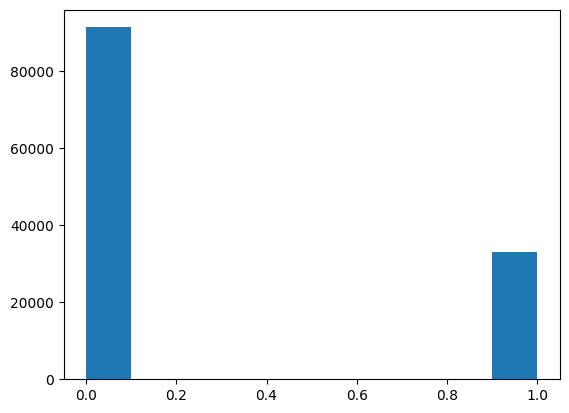

In [35]:
# why is this distribution so hard-splitted?..
plt.hist(x=data_2['inappropriate'], bins=10)
# plt.hist(x=pd.read_csv('data/raw/data_2/Inappapropriate_messages_last.csv')['inappropriate'], bins=10)

In [36]:
data_2 = data_2.rename(columns=COLUMNS_MAP)

In [37]:
data_2.head()

,text_raw,inappropriate
0,"Бедный Ниссон, его бесконечных детей то похища...",0.9526
1,Все кто лишился девстенности после NUMBER - ом...,0.9972
2,Не знаю сам почему её туда отправили. Не торга...,0.0217
3,Проституция легальнаНелегальное предпринимател...,0.9986
4,"Я бы повстречался с порноактрисой, только я не...",0.9998


In [38]:
data_2_bunch = pd.DataFrame(columns=df_common.columns, data=data_2)

data_2_bunch['dataset_id'] = 2
data_2_bunch['source_platform'] = '2ch.hk, Pikabu.ru, otveti.mail.ru'

# yandex.toloka passed as the labelling method => is_verified=1: 
data_2_bunch['is_verified'] = 1 

data_2_bunch['toxicity_type'] = (
    data_2_bunch['toxicity_type'].fillna('')
).astype(str)


# data_1_bunch['label'] = data_1_bunch['label'].astype(int)
data_2_bunch.head()

,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type
0,NaN,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,"Бедный Ниссон, его бесконечных детей то похища...",NaN,
1,NaN,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,Все кто лишился девстенности после NUMBER - ом...,NaN,
2,NaN,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,Не знаю сам почему её туда отправили. Не торга...,NaN,
3,NaN,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,Проституция легальнаНелегальное предпринимател...,NaN,
4,NaN,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,"Я бы повстречался с порноактрисой, только я не...",NaN,


The rows in this dataset are named as related to dangerous themes.  
=> we can't name those rows as normal, even if INAPPROPRIATE== 0. All those themes are sensitive at least. 

In [39]:
data_2_bunch['toxicity_type'] = data_2['inappropriate'].apply(lambda r: 'INAPPROPRIATE' if r >= 0.5 else 'SENSITIVE')
data_2_bunch.head()

,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type
0,NaN,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,"Бедный Ниссон, его бесконечных детей то похища...",NaN,INAPPROPRIATE
1,NaN,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,Все кто лишился девстенности после NUMBER - ом...,NaN,INAPPROPRIATE
2,NaN,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,Не знаю сам почему её туда отправили. Не торга...,NaN,SENSITIVE
3,NaN,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,Проституция легальнаНелегальное предпринимател...,NaN,INAPPROPRIATE
4,NaN,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,"Я бы повстречался с порноактрисой, только я не...",NaN,INAPPROPRIATE


In [40]:
# binary labels want to be passed and checked in future experiments.
data_2_bunch.head()

,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type
0,NaN,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,"Бедный Ниссон, его бесконечных детей то похища...",NaN,INAPPROPRIATE
1,NaN,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,Все кто лишился девстенности после NUMBER - ом...,NaN,INAPPROPRIATE
2,NaN,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,Не знаю сам почему её туда отправили. Не торга...,NaN,SENSITIVE
3,NaN,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,Проституция легальнаНелегальное предпринимател...,NaN,INAPPROPRIATE
4,NaN,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,"Я бы повстречался с порноактрисой, только я не...",NaN,INAPPROPRIATE


In [41]:
data_2_bunch.dtypes

raw_text_id        float64
dataset_id           int64
source_platform     object
is_verified          int64
text_raw            object
is_toxic           float64
toxicity_type       object
dtype: object

In [42]:
data_2_bunch.isna().sum()

raw_text_id        124597
dataset_id              0
source_platform         0
is_verified             0
text_raw                0
is_toxic           124597
toxicity_type           0
dtype: int64

In [43]:
data_2_bunch = data_2_bunch.drop_duplicates(subset='text_raw', keep='first')

In [44]:
df_common = merge_on_schema(df_common, data_2_bunch)

f:\HSE\level-1\Year-project\Sources\toxic-messages-handling-project\.venv\Lib\site-packages\great_expectations\expectations\expectation.py:1490: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(
Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00, 687.42it/s] 
f:\HSE\level-1\Year-project\Sources\toxic-messages-handling-project\.venv\Lib\site-packages\great_expectations\expectations\expectation.py:1490: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(
Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00, 921.32it/s] 
f:\HSE\level-1\Year-project\Sources\toxic-messages-handling-project\.venv\Lib\site-packages\great_expectations\expectations\expectation.py:1490: UserWarning: `result_format` configured

Warning! Dtype of raw_text_id = float64, expected int
Warning! Dtype of dataset_id = int64, expected string
Warning! Dtype of source_platform = object, expected string
Warning! Dtype of is_verified = int64, expected float
Warning! Dtype of text_raw = object, expected string
Warning! Dtype of is_toxic = float64, expected int
Warning! Dtype of toxicity_type = object, expected string


Calculating Metrics: 100%|██████████| 25/25 [00:00<00:00, 111.78it/s]


Batch is valid!


f:\HSE\level-1\Year-project\Sources\toxic-messages-handling-project\.venv\Lib\site-packages\great_expectations\expectations\expectation.py:1490: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(
Calculating Metrics: 100%|██████████| 8/8 [00:00<00:00, 30.20it/s]  


In [45]:
df_common.tail()

,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type
387276,387276,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,Я тоже люблю вздрочнуть наедине под порно. По ...,NaN,INAPPROPRIATE
387277,387277,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,Работы нет в регионах. Зарплата NUMBER тыр . ...,NaN,INAPPROPRIATE
387278,387278,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,"Не, ну дедок который на Энергомаше фрезеровщик...",NaN,SENSITIVE
387279,387279,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,Экономика в жопе. В России всё в жопе!,NaN,INAPPROPRIATE
387280,387280,2,"2ch.hk, Pikabu.ru, otveti.mail.ru",1,Какой в жопу патриархат? Ещё в СССР добились п...,NaN,INAPPROPRIATE


In [46]:
df_common.shape

(387281, 7)

## id 3 ## 
data is not found, boooooo

## id 4 ## 

In [47]:
data_4 = pd.concat([
    pd.read_parquet(data_4_train_path),
    pd.read_parquet(data_4_test_path)
])

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

In [ ]:
data_4.head()

,text,label
0,"сильный лидер не врет, сильный лидер не пидр, ...",0
1,на исходном фото надпись: вот так наша бабуля ...,1
2,► Получайте заказы &quot;Мастер на час&quot; в...,1
3,а вдруг и свершится чудо ! а какая моя душа ?,1
4,"[id731232234|Count], я бы и ленту закрыл, чтоб...",1


In [ ]:
# labels are reversed in this dataset => fix that: 
data_4.loc[:, 'is_toxic'] = data_4.loc[:, 'label'].apply(lambda x: 1 if x==0 else 0)

In [ ]:
data_4.head()

,text,label,is_toxic
0,"сильный лидер не врет, сильный лидер не пидр, ...",0,1
1,на исходном фото надпись: вот так наша бабуля ...,1,0
2,► Получайте заказы &quot;Мастер на час&quot; в...,1,0
3,а вдруг и свершится чудо ! а какая моя душа ?,1,0
4,"[id731232234|Count], я бы и ленту закрыл, чтоб...",1,0


In [ ]:
data_4 = data_4.rename(columns=COLUMNS_MAP)
data_4_bunch = pd.DataFrame(columns=df_common.columns, data=data_4)

data_4_bunch['dataset_id'] = 4
data_4_bunch['source_platform'] = '2ch, vk' # 

# hugging face dataset without any information about labelling or corectness. => can't pass it as verified 
data_4_bunch['is_verified'] = 0 
data_4_bunch['toxicity_type'] = (
    data_4_bunch['toxicity_type'].fillna('')
).astype(str)


data_4_bunch['is_toxic'] = data_4_bunch['is_toxic'].astype(int)
data_4_bunch.head()

,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type
0,NaN,4,"2ch, vk",0,"сильный лидер не врет, сильный лидер не пидр, ...",1,
1,NaN,4,"2ch, vk",0,на исходном фото надпись: вот так наша бабуля ...,0,
2,NaN,4,"2ch, vk",0,► Получайте заказы &quot;Мастер на час&quot; в...,0,
3,NaN,4,"2ch, vk",0,а вдруг и свершится чудо ! а какая моя душа ?,0,
4,NaN,4,"2ch, vk",0,"[id731232234|Count], я бы и ленту закрыл, чтоб...",0,


In [ ]:
# trying to merge dfs and check out how does the expectations of intersection work: 
try: 
    merge_on_schema(df_common, data_4_bunch)
except Exception as ex:
    print(ex)

f:\HSE\level-1\Year-project\Sources\toxic-messages-handling-project\.venv\Lib\site-packages\great_expectations\expectations\expectation.py:1487: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(
Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00, 1127.80it/s]
f:\HSE\level-1\Year-project\Sources\toxic-messages-handling-project\.venv\Lib\site-packages\great_expectations\expectations\expectation.py:1487: UserWarning: `result_format` configured at the Validator-level will not be persisted. Please add the configuration to your Checkpoint config or checkpoint_run() method instead.
  warnings.warn(
Calculating Metrics: 100%|██████████| 2/2 [00:00<00:00, 1143.33it/s]
f:\HSE\level-1\Year-project\Sources\toxic-messages-handling-project\.venv\Lib\site-packages\great_expectations\expectations\expectation.py:1487: UserWarning: `result_format` configured

Warning! Dtype of raw_text_id = float64, expected int
Warning! Dtype of dataset_id = int64, expected string
Warning! Dtype of source_platform = object, expected string
Warning! Dtype of is_verified = int64, expected float
Warning! Dtype of text_raw = object, expected string
Warning! Dtype of toxicity_type = object, expected string


Calculating Metrics: 100%|██████████| 25/25 [00:00<00:00, 35.25it/s] 

Batch is incorrect! The following expectations failed:

                            expectation   column  success  unexpected_count  unexpected_percent                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

### Demo of GE pros

Great expectations is the processing layer that tells us about the problems in dataset to resolve. 
The specific ouptut of the problem is:   
{'success': False, 'expectation_config': {'type': 'expect_column_values_to_not_match_regex', 'kwargs': {'batch_id': 'pandas dataframes-df_bunch_asset', 'column': 'text_raw', 'regex': '^\\s*$'}

regex expectation checks on the empty rows => delete them:  
also, duplicates with primary df found, => delete duplicates in batch df:  

In [ ]:
data_4_bunch[data_4_bunch['text_raw']==''].shape

(13583, 7)

In [ ]:
data_4_bunch = data_4_bunch[data_4_bunch['text_raw']!='']
data_4_bunch= data_4_bunch[~data_4_bunch['text_raw'].isin(df_common['text_raw'])]
data_4_bunch = data_4_bunch.drop_duplicates(subset='text_raw')
data_4_bunch.shape

(62012, 7)

trying to merge one more time => success: 

In [ ]:
df_common = merge_on_schema(df_common, data_4_bunch)

In [ ]:
df_common.to_csv(df_common_path)

In [ ]:
df_common.shape

(449293, 7)

## id 5 ## 

In [ ]:
data_5 = pd.read_csv(data_5_path, sep='\t')

In [ ]:
data_5.head()

,comment_id,source,comments,distortion,toxicity,corrected
0,188,медуза,"[id2685300|Максим], а, её уже заставили??ДАННО...",0,0,NaN
1,396,медуза,разасраться с братскими народами и стать на ко...,0,0,NaN
2,1014,лентач,три четыре пять шесть семь,0,0,NaN
3,1101,лентач,"[id182444802|Роман], уже",0,0,NaN
4,197,медуза,всех с 14 февраля,0,0,NaN


In [ ]:
data_5['comments'].isna().sum()

np.int64(103)

In [ ]:
data_5['corrected'].isna().sum()

np.int64(2873)

In [ ]:
data_5.isna().sum()

comment_id       0
source           0
comments       103
distortion       0
toxicity         0
corrected     2873
dtype: int64

In [ ]:
data_5 = data_5.rename(columns=COLUMNS_MAP)
pd.DataFrame(columns=df_common.columns, data=data_5)

,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type
0,NaN,NaN,медуза,NaN,"[id2685300|Максим], а, её уже заставили??ДАННО...",0,NaN
1,NaN,NaN,медуза,NaN,разасраться с братскими народами и стать на ко...,0,NaN
2,NaN,NaN,лентач,NaN,три четыре пять шесть семь,0,NaN
3,NaN,NaN,лентач,NaN,"[id182444802|Роман], уже",0,NaN
4,NaN,NaN,медуза,NaN,всех с 14 февраля,0,NaN
...,...,...,...,...,...,...,...
2995,NaN,NaN,дождь,NaN,"[id664517645|Игорь],",0,NaN
2996,NaN,NaN,медуза,NaN,"[id164778106|Алексей], узкой педофильской ауди...",0,NaN
2997,NaN,NaN,дождь,NaN,"[id461498232|Андрей], кстати, я знаю зачем нуж...",0,NaN
2998,NaN,NaN,медуза,NaN,"[id6047001|Петр], так речь идёт о государствен...",0,NaN


In [ ]:

data_5_bunch = pd.DataFrame(columns=df_common.columns, data=data_5)

data_5_bunch['dataset_id'] = 5
# data_5_bunch['source_platform'] = 'vk, other' # vk passed explicitly, "several source data" named to other
# https://github.com/alla-g/toxicity-detection-thesis/tree/main?tab=readme-ov-file


data_5_bunch['is_verified'] = 0 
data_5_bunch['toxicity_type'] = (
    data_5_bunch['toxicity_type'].fillna('')
).astype(str)

data_5_bunch['is_toxic'] = data_5_bunch['is_toxic'].astype(int)
data_5_bunch.dropna(subset='text_raw', inplace=True)

data_5_bunch.head()

,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type
0,NaN,5,медуза,0,"[id2685300|Максим], а, её уже заставили??ДАННО...",0,
1,NaN,5,медуза,0,разасраться с братскими народами и стать на ко...,0,
2,NaN,5,лентач,0,три четыре пять шесть семь,0,
3,NaN,5,лентач,0,"[id182444802|Роман], уже",0,
4,NaN,5,медуза,0,всех с 14 февраля,0,


In [ ]:
data_5_bunch.shape

(2897, 7)

In [ ]:
data_5_bunch[~data_5_bunch['text_raw'].isin(df_common['text_raw'])].shape

(2896, 7)

In [ ]:
data_5_bunch[~data_5_bunch['text_raw'].isin(df_common['text_raw'])]

,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type
0,NaN,5,медуза,0,"[id2685300|Максим], а, её уже заставили??ДАННО...",0,
1,NaN,5,медуза,0,разасраться с братскими народами и стать на ко...,0,
2,NaN,5,лентач,0,три четыре пять шесть семь,0,
3,NaN,5,лентач,0,"[id182444802|Роман], уже",0,
4,NaN,5,медуза,0,всех с 14 февраля,0,
...,...,...,...,...,...,...,...
2995,NaN,5,дождь,0,"[id664517645|Игорь],",0,
2996,NaN,5,медуза,0,"[id164778106|Алексей], узкой педофильской ауди...",0,
2997,NaN,5,дождь,0,"[id461498232|Андрей], кстати, я знаю зачем нуж...",0,
2998,NaN,5,медуза,0,"[id6047001|Петр], так речь идёт о государствен...",0,


In [ ]:
# unickness: 
data_5[~data_5['text_raw'].isin(df_common['text_raw'])].shape

(2999, 6)

In [ ]:
data_5_bunch = data_5_bunch[~data_5_bunch['text_raw'].isin(df_common['text_raw'])]
data_5_bunch = data_5_bunch[data_5_bunch['text_raw'] != ' ']
data_5_bunch.dropna(subset='text_raw', inplace=True)
data_5_bunch.drop_duplicates(subset='text_raw', inplace=True)

In [ ]:
data_5_bunch.shape

(2843, 7)

In [ ]:
data_5_bunch.head()

,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type
0,NaN,5,медуза,0,"[id2685300|Максим], а, её уже заставили??ДАННО...",0,
1,NaN,5,медуза,0,разасраться с братскими народами и стать на ко...,0,
2,NaN,5,лентач,0,три четыре пять шесть семь,0,
3,NaN,5,лентач,0,"[id182444802|Роман], уже",0,
4,NaN,5,медуза,0,всех с 14 февраля,0,


In [ ]:
df_common = merge_on_schema(df_common, data_5_bunch)

## id 6 ## 

In [ ]:
data_6 = pd.read_csv(data_6_path)
data_6.head()

,id,video_id,author,text,abusive
0,Ugg-760PTdEPkXgCoAEC,3KyjqEmLJ7E,ИЛЬЯ МУРОМЕЦ,всем холодный душ из водомётов и не одного евр...,True
1,UgjBgygn4Vx-XngCoAEC,BU3i_j000iA,171marela,я поляк я люблю тебе,False
2,UgiV35tri5TvZ3gCoAEC,fcfF_63Rk_o,Red Scorpio,автор хуй из рта вытащи беркут герои,True
3,UgiYhfSCC5t3o3gCoAEC,5eTgme4dcFg,Яга Баба-Яга,позор януковичу не замочил майданщиков продажн...,True
4,UghO9NcLpbcEIXgCoAEC.7-H0Z7-3vFX70NqAnnuUSs,gWKCJyq_kJ8,Zavalnik Zav,легче всего обвинять россию,False


In [ ]:
data_6 = data_6.rename(columns=COLUMNS_MAP)
data_6_bunch = pd.DataFrame(columns=df_common.columns, data=data_6)

data_6_bunch['dataset_id'] = 6
data_6_bunch['source_platform'] = 'YouTube' 
data_6_bunch['is_verified'] = 0 
data_6_bunch['toxicity_type'] = (
    data_6_bunch['toxicity_type'].fillna('')
).astype(str)

data_6_bunch['is_toxic'] = data_6_bunch['is_toxic'].astype(int)
# data_6_bunch.dropna(subset='text_raw', inplace=True)

data_6_bunch.head()

,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type
0,NaN,6,YouTube,0,всем холодный душ из водомётов и не одного евр...,1,
1,NaN,6,YouTube,0,я поляк я люблю тебе,0,
2,NaN,6,YouTube,0,автор хуй из рта вытащи беркут герои,1,
3,NaN,6,YouTube,0,позор януковичу не замочил майданщиков продажн...,1,
4,NaN,6,YouTube,0,легче всего обвинять россию,0,


In [ ]:
data_6_bunch[~data_6_bunch['text_raw'].isin(df_common['text_raw'])].shape

(2000, 7)

In [ ]:
data_6_bunch = data_6_bunch[data_6_bunch['text_raw']!='']
data_6_bunch = data_6_bunch[data_6_bunch['text_raw']!=' ']
data_6_bunch.dropna(subset='text_raw', inplace=True)
data_6_bunch = data_6_bunch.drop_duplicates(subset='text_raw')

In [ ]:
data_6_bunch.head()

,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type
0,NaN,6,YouTube,0,всем холодный душ из водомётов и не одного евр...,1,
1,NaN,6,YouTube,0,я поляк я люблю тебе,0,
2,NaN,6,YouTube,0,автор хуй из рта вытащи беркут герои,1,
3,NaN,6,YouTube,0,позор януковичу не замочил майданщиков продажн...,1,
4,NaN,6,YouTube,0,легче всего обвинять россию,0,


In [ ]:
df_common = merge_on_schema(df_common, data_6_bunch)

In [ ]:
df_common.shape

(454100, 7)

## id 7 ## 

In [ ]:
data_7 = pd.read_csv(data_7_path, sep=';', index_col=0)

In [ ]:
data_7.head()

,index,text,sentiment,hate_speech
0,0,на работе был полный пиддес :| и так каждое за...,-1,0.0
1,1,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,1.0
2,2,@elina_4post как говорят обещаного три года жд...,-1,0.0
3,3,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0.0
4,4,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0.0


In [ ]:
data_7 = data_7.rename(columns=COLUMNS_MAP)
data_7_bunch = pd.DataFrame(columns=df_common.columns, data=data_7)

data_7_bunch['dataset_id'] = 7
data_7_bunch['source_platform'] = 'Social Media, TV-Scripts (South Park)' 

# info about labeelling is not passed: 
data_7_bunch['is_verified'] = 0 
data_7_bunch['toxicity_type'] = (
    data_7_bunch['toxicity_type'].fillna('')
).astype(str)
data_7_bunch['is_toxic'] = data_7_bunch['is_toxic'].astype(int)

data_7_bunch.head()

,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type
0,NaN,7,"Social Media, TV-Scripts (South Park)",0,на работе был полный пиддес :| и так каждое за...,0,
1,NaN,7,"Social Media, TV-Scripts (South Park)",0,"Коллеги сидят рубятся в Urban terror, а я из-з...",1,
2,NaN,7,"Social Media, TV-Scripts (South Park)",0,@elina_4post как говорят обещаного три года жд...,0,
3,NaN,7,"Social Media, TV-Scripts (South Park)",0,"Желаю хорошего полёта и удачной посадки,я буду...",0,
4,NaN,7,"Social Media, TV-Scripts (South Park)",0,"Обновил за каким-то лешим surf, теперь не рабо...",0,


In [ ]:
data_7_bunch.drop_duplicates(subset='text_raw', inplace=True)

In [ ]:
df_common = merge_on_schema(df_common, data_7_bunch)

In [ ]:
df_common.shape

(469967, 7)

In [ ]:
df_common.to_csv(df_common_path)

In [ ]:
df_common['is_toxic'].isna().sum()

np.int64(135164)

In [ ]:
df_common.head()

,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type
0,0,0,"2ch, pikabu",1,"Верблюдов-то за что? Дебилы, бл...\n",1.0,
1,1,0,"2ch, pikabu",1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,
2,2,0,"2ch, pikabu",1,Собаке - собачья смерть\n,1.0,
3,3,0,"2ch, pikabu",1,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,
4,4,0,"2ch, pikabu",1,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,


## id 8

In [ ]:
data_8 = pd.read_csv(data_8_path)

In [ ]:
data_8.head(2)

,text,offline_crime,online_crime,drugs,gambling,pornography,prostitution,slavery,suicide,terrorism,weapons,body_shaming,health_shaming,politics,racism,religion,sexual_minorities,sexism,social_injustice
0,РРРРРРЯЯЯЯЯЯЯ РУССКИЕ ВАНЬКИ НИКОМУ НЕ НУЖНЫ!!...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,"По моему, быдло тот кто осуждает чужие предпоч...",0.0,0.0,0.0,0.0,1.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
data_8.shape

(33303, 19)

How much data does each category contain? Is it necessary to add those columns data as a separate multilabel values?  
Or is it possible to transform these values into existing labels? 

In [ ]:
cols = [col for col in data_8.columns if col!='text']

for col in cols: 
    print(col)
    dat = data_8.loc[data_8[data_8[col]==1].index, :]
    print(dat.shape[0])
    print(dat.text.values[:3])

Check the appropriateness: 
* "onine/offline crime" -> THREAT


In [ ]:
cols

['offline_crime',
 'online_crime',
 'drugs',
 'gambling',
 'pornography',
 'prostitution',
 'slavery',
 'suicide',
 'terrorism',
 'weapons',
 'body_shaming',
 'health_shaming',
 'politics',
 'racism',
 'religion',
 'sexual_minorities',
 'sexism',
 'social_injustice']

The data is too heterogeneous to be correctly added to the general dataset

## Review of the corectness, save

In [ ]:
df_common.shape

(469967, 7)

In [ ]:
df_common.drop_duplicates(subset='text_raw', inplace=True)
df_common.shape

(455551, 7)

In [ ]:
df_common.toxicity_type.unique() # <- corrected multiple labels in the rows

<StringArray>
[                       '',                  'INSULT',
                  'NORMAL',           'INSULT,THREAT',
        'INSULT,OBSCENITY',               'OBSCENITY',
                  'THREAT',        'OBSCENITY,THREAT',
 'INSULT,OBSCENITY,THREAT',           'INAPPROPRIATE',
               'SENSITIVE']
Length: 11, dtype: string

In [ ]:
df_common.to_csv(df_common_path)

## Conclusions of data collection 
* Great expectations may be really useful in simple realtime data pipelines. But in the static processing it's slightly redundant (but it's still cool to take a look at this library);
* Data imbalance was found in single class labelling (200+k nontoxic vs ~50k toxic). 
* 455551 rows is a summary count of rows which are include multi- and single labels. 

### Steps to be done
* Run the existing models (ML, DL, LLM/RAG) on the unlabelled data 
* Find and use the simpliest cloud storage as possible to use in this task to store the raw data, precomputed features and models 

# Visualize class imbalance

At first, let's please consider the multi-label and single-label categories that are included in the common dataset. 

In [50]:
df = pd.read_csv('data/raw/df_common.csv', index_col=0)

In [51]:
df.head()

,raw_text_id,dataset_id,source_platform,is_verified,text_raw,is_toxic,toxicity_type
0,0,0,"2ch, pikabu",1,"Верблюдов-то за что? Дебилы, бл...\n",1.0,NaN
1,1,0,"2ch, pikabu",1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,NaN
2,2,0,"2ch, pikabu",1,Собаке - собачья смерть\n,1.0,NaN
3,3,0,"2ch, pikabu",1,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,NaN
4,4,0,"2ch, pikabu",1,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,NaN


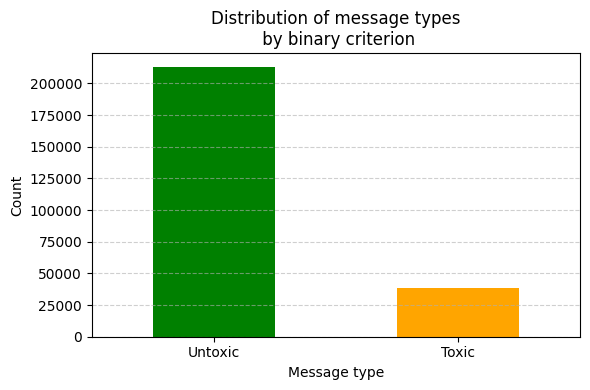

In [53]:
import matplotlib.pyplot as plt

counts = df['is_toxic'].value_counts()

# Построение столбчатой диаграммы
plt.figure(figsize=(6, 4))
counts.plot(kind='bar', color=['green', 'orange'])
plt.title('Distribution of message types\n by binary criterion')
plt.xlabel('Message type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Untoxic', 'Toxic'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()